<a href="https://colab.research.google.com/github/benson85560/yuanta/blob/main/Pct_change_Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Preparation**

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import datetime as dt
import time
from pandas.core.tools.datetimes import to_datetime
import math as m

path = os.getcwd()
print(path)

/content


In [2]:
!pip install yfinance
import yfinance as yf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.5 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [3]:
#Colab安裝Talib
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib

--2022-08-11 23:46:11--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 204.68.111.105
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|204.68.111.105|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2022-08-11 23:46:11--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://gigenet.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2022-08-11 23:46:11--  http://gigenet.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving gigenet.dl.sour

In [4]:
import talib 
from talib import abstract

## **pct_change strategy**

### for single model

In [ ]:
symbol = '0052.TW'
print(f'---loading: {symbol}---')
data = yf.Ticker(symbol)
df = data.history(period='D', start='2009-10-26', end='2022-6-30')
df = df.drop(columns = ['Dividends', 'Stock Splits'])
df.columns = ['open', 'high', 'low', 'close', 'volume']
df['SAR'] = abstract.SAR(df)
df['pct_30'] = df['close'].pct_change(10)
df['rolling'] = df['close'].rolling(10, win_type ='triang').std()
df['pct_1'] = df['close'].pct_change(1)

Yield = pd.read_csv(path + '/yield.csv')
Yield = Yield.set_index(pd.to_datetime(Yield['Date']))
Yield = Yield.drop('Date', axis = 1)
df = pd.merge(df, Yield, how = 'left', left_index = True, right_index=True)

fund = 100 #初始有100元本金
money = 100 #每次投入100元
feeRate = 0.003

first = 0 ##除了第一筆之外，只紀錄出場的時間點
BS = None ##紀錄現在的狀態是做多還做空
stopEarn = 0
stopLoss = 0

#--------# 記錄買入、賣出時間點
buy = []
sell_win = []
sell_lose = []
#--------# 
timeList = [] 
profit_list = [0]
profit_fee_list = [0]


for i in range(len(df)):

    if first == 0:
        timeList.append(df.index[i+1])
        first = 1
        continue

    if i == len(df)-1: # last trading day
        break

      
     
      # 除息日                      # BS: position, B: buy, S: sell
    if df[symbol][i] > 0 and abs(df['pct_30'][i]) > abs(df['pct_30'][i-1]) * 1.5 and BS == None: # and abs(df['pct_30'][i]) > abs(df['pct_30'][i-1]) * 3
        BS = 'OK' 
        continue

      # buy
    if BS == 'OK' and df['pct_1'][i] > 0: # 等反轉再進場
        temp = df['close'][i+1] 
        tempSize = money / temp
        BS = 'B' 
        buy.append(i+1)
        stopLoss = df['SAR'][i+1] * 0.9
        stopEarn = df['close'][i+1] + (abs((df['close'][i+1] - df['SAR'][i+1])) * 1.1)
        continue

        
      # 停利
    if df['close'][i] > stopEarn and BS == 'B':
        profit = tempSize * (df['close'][i+1] - temp) 
        profit_fee = profit - money*feeRate - (money+profit)*feeRate
        profit_fee_list.append(profit_fee)
        profit_list.append(profit)
        sell_win.append(i+1)
        timeList.append(df.index[i])
        BS=None
        continue

      # 停損
    if df['close'][i] < stopLoss and BS == 'B':
        profit = tempSize * (df['close'][i+1] - temp) 
        profit_fee = profit - money*feeRate - (money+profit)*feeRate
        profit_fee_list.append(profit_fee)
        profit_list.append(profit)
        sell_lose.append(i+1)
        timeList.append(df.index[i])
        BS=None
        continue
    
# equity = pd.DataFrame({'profit':profit_list}, index=timeList)
equity = pd.DataFrame({'profit':np.cumsum(profit_list)}, index=timeList)
equity

---loading: 0052.TW---


,profit
2009-10-27,0.000000
2010-05-12,1.540395
2012-05-09,1.080621
2014-05-26,8.886806
2016-05-06,8.285261
2019-05-20,-0.221527
2022-06-22,-8.582414


buy:DatetimeIndex(['2010-05-10', '2012-05-09', '2014-05-08', '2016-05-06',
               '2019-05-06', '2022-04-29'],
              dtype='datetime64[ns]', name='Date', freq=None)
win:DatetimeIndex(['2014-05-27'], dtype='datetime64[ns]', name='Date', freq=None)
lose:DatetimeIndex(['2010-05-13', '2012-05-10', '2016-05-09', '2019-05-21',
               '2022-06-23'],
              dtype='datetime64[ns]', name='Date', freq=None)
--------------
win ratio :0.16666666666666666


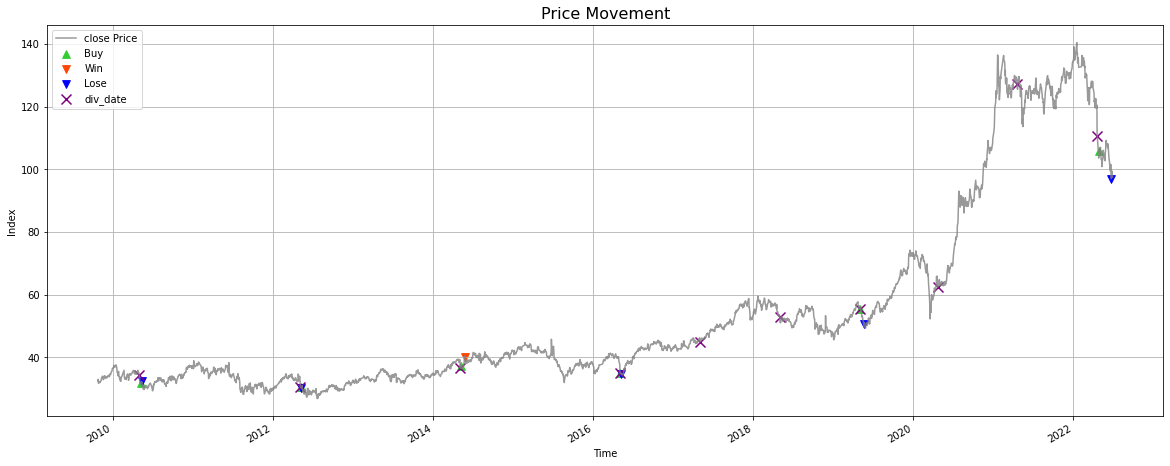

In [ ]:
# 實際交易位置
List = []
for i in range(len(df)):
  if df[symbol][i] > 0:
    List.append(df.index[i])

print('buy:{}'.format(df.iloc[buy].index))
print('win:{}'.format(df.iloc[sell_win].index))
print('lose:{}'.format(df.iloc[sell_lose].index))
print('--------------')
print('win ratio :{}'.format(len(sell_win)/len(buy)))

fig, ax = plt.subplots(figsize = (20,8))
df['close'].plot(label = 'close Price', ax = ax, c = 'gray', grid=True, alpha=0.8)
plt.scatter(df['close'].iloc[buy].index, df['close'].iloc[buy],c = 'limegreen', label = 'Buy', marker='^', s=60)
plt.scatter(df['close'].iloc[sell_win].index, df['close'].iloc[sell_win],c = 'orangered', label = 'Win', marker='v', s=60)
plt.scatter(df['close'].iloc[sell_lose].index, df['close'].iloc[sell_lose],c = 'b', label = 'Lose', marker='v', s=60)
plt.scatter(df['close'].loc[List].index, df['close'].loc[List],c = 'purple', label = 'div_date', marker='x', s=100)

# plt.xlim('2019-09-01', '2020-09-01')
# plt.ylim(25, 30)

plt.legend()
plt.ylabel('Index')
plt.xlabel('Time')
plt.title('Price Movement',fontsize  = 16);

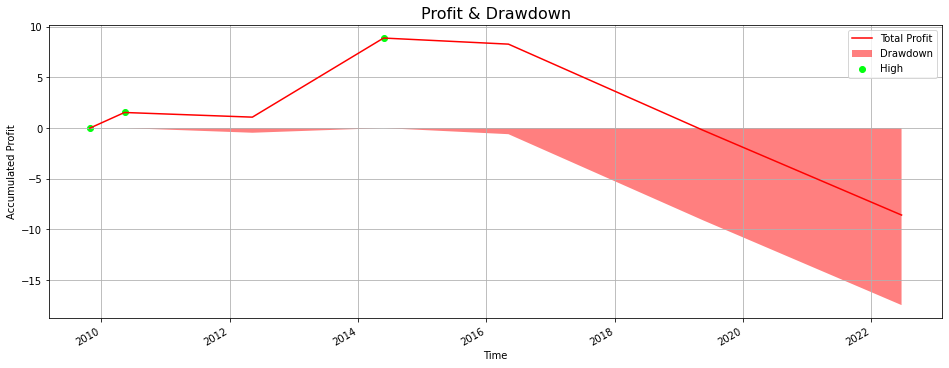

In [ ]:
equity['equity'] = equity['profit'] + fund
equity['drawdown_percent'] = (equity['equity'] / equity['equity'].cummax()) - 1
equity['drawdown'] = equity['equity'] - equity['equity'].cummax()

fig, ax = plt.subplots(figsize = (16,6))

high_index = equity[equity['profit'].cummax() == equity['profit']].index
equity['profit'].plot(label = 'Total Profit', ax = ax, c = 'r', grid=True)
plt.fill_between(equity['drawdown'].index, equity['drawdown'], 0, facecolor  = 'r', label = 'Drawdown', alpha=0.5)
plt.scatter(high_index, equity['profit'].loc[high_index],c = '#02ff0f', label = 'High')

plt.legend()
plt.ylabel('Accumulated Profit')
plt.xlabel('Time')
plt.title('Profit & Drawdown',fontsize  = 16);


### for all

In [ ]:
symbol = '0050.TW'
print(f'---loading: {symbol}---')
data = yf.Ticker(symbol)
df = data.history(period='D', start='2009-10-26', end='2022-6-30')
df = df.drop(columns = ['Dividends', 'Stock Splits'])
df.columns = ['open', 'high', 'low', 'close', 'volume']
df['SAR'] = abstract.SAR(df)
df['pct_30'] = df['close'].pct_change(10)
df['rolling'] = df['close'].rolling(10, win_type ='triang').std()
df['pct_1'] = df['close'].pct_change(1)

Yield = pd.read_csv(path + '/yield.csv')
Yield = Yield.set_index(pd.to_datetime(Yield['Date']))
Yield = Yield.drop('Date', axis = 1)
df = pd.merge(df, Yield, how = 'left', left_index = True, right_index=True)

fund = 100 #初始有100元本金
money = 100 #每次投入100元
feeRate = 0.003

first = 0 ##除了第一筆之外，只紀錄出場的時間點
BS = None ##紀錄現在的狀態是做多還做空
stopEarn = 0
stopLoss = 0

#--------# 記錄買入、賣出時間點
buy = []
sell_win = []
sell_lose = []
#--------# 
timeList = [] 
profit_list = [0]
profit_fee_list = [0]

#--------# ratio cal.
win_ratio = []
err_ratio = []


for i in range(len(df)):

    if first == 0:
        timeList.append(df.index[i+1])
        first = 1
        continue

    if i == len(df)-1: # last trading day
        break
     
      # 除息日                      # BS: position, B: buy, S: sell
    if df[symbol][i] > 0 and abs(df['pct_30'][i]) > abs(df['pct_30'][i-1]) * 1.5 and BS == None: # and abs(df['pct_30'][i]) > abs(df['pct_30'][i-1]) * 3
        BS = 'OK' 
        continue

      # buy
    if BS == 'OK' and df['pct_1'][i] > 0: # 等反轉再進場
        temp = df['close'][i+1] 
        tempSize = money / temp
        BS = 'B' 
        buy.append(i+1)
        stopLoss = df['SAR'][i+1] * 0.9
        stopEarn = df['close'][i+1] + (abs((df['close'][i+1] - df['SAR'][i+1])) * 1.1)
        continue

        
      # 停利
    if df['close'][i] > stopEarn and BS == 'B':
        profit = tempSize * (df['close'][i+1] - temp) 
        profit_fee = profit - money*feeRate - (money+profit)*feeRate
        profit_fee_list.append(profit_fee)
        profit_list.append(profit)
        sell_win.append(i+1)
        timeList.append(df.index[i])
        BS=None
        continue

      # 停損
    if df['close'][i] < stopLoss and BS == 'B':
        profit = tempSize * (df['close'][i+1] - temp) 
        profit_fee = profit - money*feeRate - (money+profit)*feeRate
        profit_fee_list.append(profit_fee)
        profit_list.append(profit)
        sell_lose.append(i+1)
        timeList.append(df.index[i])
        BS=None
        continue
    
# equity = pd.DataFrame({'profit':profit_list}, index=timeList)
equity = pd.DataFrame({'0050.TW':np.cumsum(profit_list)}, index=timeList)
win_ratio.append(len(sell_win)/len(buy))

########-------------------------------------------------------------#########

symbol_list = ['0051.TW', '0052.TW', '0053.TW', '0055.TW', '0056.TW', '006203.TW', '006204.TW', '006208.TW', 
               '00690.TW', '00692.TW', '00701.TW', '00712.TW', '00713.TW', '00714.TW', '00717.TW',
               '00728.TW', '00730.TW', '00731.TW', '00733.TW', '00735.TW']

for j in range(len(symbol_list)):
  symbol = symbol_list[j]

  print(f'---loading: {symbol}---')

  data = yf.Ticker(symbol)
  df = data.history(period='D', start='2009-10-26', end='2022-6-30')
  df = df.drop(columns = ['Dividends', 'Stock Splits'])
  df.columns = ['open', 'high', 'low', 'close', 'volume']
  df['SAR'] = abstract.SAR(df)
  df['pct_30'] = df['close'].pct_change(10)
  # df['rolling'] = df['close'].rolling(10, win_type ='triang').std()
  df['pct_1'] = df['close'].pct_change(1)

  Yield = pd.read_csv(path + '/yield.csv')
  Yield = Yield.set_index(pd.to_datetime(Yield['Date']))
  Yield = Yield.drop('Date', axis = 1)
  df = pd.merge(df, Yield, how = 'left', left_index = True, right_index=True)

  fund = 100 #初始有100元本金
  money = 100 #每次投入100元
  feeRate = 0.003

  first = 0 ##除了第一筆之外，只紀錄出場的時間點
  BS = None ##紀錄現在的狀態是做多還做空
  stopEarn = 0
  stopLoss = 0

  #--------# 記錄買入、賣出時間點
  buy = []
  sell_win = []
  sell_lose = []
  #--------# 
  timeList = [] 
  profit_list = [0]
  profit_fee_list = [0]


  for i in range(len(df)):

      if first == 0:
          timeList.append(df.index[i+1])
          first = 1
          continue

      if i == len(df)-1: # last trading day
          break
      
          # 除息日                      # BS: position, B: buy, S: sell
      if df[symbol][i] > 0 and abs(df['pct_30'][i]) > abs(df['pct_30'][i-1]) * 1.5 and BS == None: # and abs(df['pct_30'][i]) > abs(df['pct_30'][i-1]) * 3
          BS = 'OK' 
          continue

        # buy
      if BS == 'OK' and df['pct_1'][i] > 0: # 等反轉再進場
          temp = df['close'][i+1] 
          tempSize = money / temp
          BS = 'B' 
          buy.append(i+1)
          stopLoss = df['SAR'][i+1] * 0.9
          stopEarn = df['close'][i+1] + (abs((df['close'][i+1] - df['SAR'][i+1])) * 1.1)
          continue

          
        # 停利
      if df['close'][i] > stopEarn and BS == 'B':
          profit = tempSize * (df['close'][i+1] - temp) 
          profit_fee = profit - money*feeRate - (money+profit)*feeRate
          profit_fee_list.append(profit_fee)
          profit_list.append(profit)
          sell_win.append(i+1)
          timeList.append(df.index[i])
          BS=None
          continue

        # 停損
      if df['close'][i] < stopLoss and BS == 'B':
          profit = tempSize * (df['close'][i+1] - temp) 
          profit_fee = profit - money*feeRate - (money+profit)*feeRate
          profit_fee_list.append(profit_fee)
          profit_list.append(profit)
          sell_lose.append(i+1)
          timeList.append(df.index[i])
          BS=None
          continue
      
  pp = pd.DataFrame({'{}'.format(symbol_list[j]):profit_list}, index=timeList)
  equity = pd.concat([equity,pp], join='outer', axis=1)

  if len(buy) == 0:
    err_ratio.append('{} is NA'.format(symbol))
  else:
    win_ratio.append(len(sell_win)/len(buy))

---loading: 0050.TW---
---loading: 0051.TW---
---loading: 0052.TW---
---loading: 0053.TW---
---loading: 0055.TW---
---loading: 0056.TW---
---loading: 006203.TW---
---loading: 006204.TW---
---loading: 006208.TW---
---loading: 00690.TW---
---loading: 00692.TW---
---loading: 00701.TW---
---loading: 00712.TW---
---loading: 00713.TW---
---loading: 00714.TW---
---loading: 00717.TW---
---loading: 00728.TW---
---loading: 00730.TW---
---loading: 00731.TW---
---loading: 00733.TW---
---loading: 00735.TW---


In [ ]:
equity = equity.fillna(0)
df_ATC = equity.sum(axis = 0)
print(df_ATC, f'mean : {df_ATC.mean()}')

0050.TW      64.304428
0051.TW      29.746202
0052.TW      -8.582414
0053.TW      10.244316
0055.TW       2.605123
0056.TW      29.697305
006203.TW    -6.744602
006204.TW    10.365321
006208.TW     7.178632
00690.TW     16.206173
00692.TW     10.548857
00701.TW     12.416652
00712.TW    -17.155513
00713.TW      1.118884
00714.TW      7.985746
00717.TW     -4.794529
00728.TW     -5.265770
00730.TW     -4.662302
00731.TW     -9.703052
00733.TW     -7.101282
00735.TW     -7.996146
dtype: float64 mean : 6.210096631151184


In [ ]:
mean_win_ratio = sum(win_ratio)/len(win_ratio)
win_ratio, mean_win_ratio

([0.8571428571428571,
  0.9,
  0.16666666666666666,
  0.7142857142857143,
  0.5,
  0.7777777777777778,
  0.6,
  1.0,
  0.6666666666666666,
  1.0,
  1.0,
  1.0,
  0.3333333333333333,
  0.5,
  0.8,
  0.6,
  0.0,
  0.6666666666666666,
  0.0,
  0.0,
  0.0],
 0.5753590325018897)

# Optimization

* 參數：

1.   pct_change , 2.   stopEarn , 3.   stopLoss

*   training data：2008-2021





## pct_change



*   range:5, 40, 1
*   opt:35



In [ ]:
opt_list = []

for pct in range(5, 40, 1):

  symbol = '0050.TW'
  print('#####----------#####')
  print(f'changing date : {pct}')

  print(f'---loading: {symbol}---')

  startDay = '2008-01-01'
  endDay = '2021-01-01'

  data = yf.Ticker(symbol)
  df = data.history(period='D', start=startDay, end=endDay)
  df = df.drop(columns = ['Dividends', 'Stock Splits'])
  df.columns = ['open', 'high', 'low', 'close', 'volume']
  df['SAR'] = abstract.SAR(df)
  df['pct_30'] = df['close'].pct_change(pct)
  df['rolling'] = df['close'].rolling(10, win_type ='triang').std()
  df['pct_1'] = df['close'].pct_change(1)

  Yield = pd.read_csv(path + '/yield.csv')
  Yield = Yield.set_index(pd.to_datetime(Yield['Date']))
  Yield = Yield.drop('Date', axis = 1)
  df = pd.merge(df, Yield, how = 'left', left_index = True, right_index=True)

  fund = 100 #初始有100元本金
  money = 100 #每次投入100元
  feeRate = 0.003

  first = 0 ##除了第一筆之外，只紀錄出場的時間點
  BS = None ##紀錄現在的狀態是做多還做空
  stopEarn = 0
  stopLoss = 0

  #--------# 記錄買入、賣出時間點
  buy = []
  sell_win = []
  sell_lose = []
  #--------# 
  timeList = [] 
  profit_list = [0]
  profit_fee_list = [0]

  #--------# ratio cal.
  win_ratio = []
  err_ratio = []


  for i in range(len(df)):

      if first == 0:
          timeList.append(df.index[i+1])
          first = 1
          continue

      if i == len(df)-1: # last trading day
          break
      
        # 除息日                      # BS: position, B: buy, S: sell
      if df[symbol][i] > 0 and abs(df['pct_30'][i]) > abs(df['pct_30'][i-1]) * 1.5 and BS == None: # and abs(df['pct_30'][i]) > abs(df['pct_30'][i-1]) * 3
          BS = 'OK' 
          continue

        # buy
      if BS == 'OK' and df['pct_1'][i] > 0: # 等反轉再進場
          temp = df['close'][i+1] 
          tempSize = money / temp
          BS = 'B' 
          buy.append(i+1)
          stopLoss = df['SAR'][i+1] * 0.9
          stopEarn = df['close'][i+1] + (abs((df['close'][i+1] - df['SAR'][i+1])) * 1.1)
          continue

          
        # 停利
      if df['close'][i] > stopEarn and BS == 'B':
          profit = tempSize * (df['close'][i+1] - temp) 
          profit_fee = profit - money*feeRate - (money+profit)*feeRate
          profit_fee_list.append(profit_fee)
          profit_list.append(profit)
          sell_win.append(i+1)
          timeList.append(df.index[i])
          BS=None
          continue

        # 停損
      if df['close'][i] < stopLoss and BS == 'B':
          profit = tempSize * (df['close'][i+1] - temp) 
          profit_fee = profit - money*feeRate - (money+profit)*feeRate
          profit_fee_list.append(profit_fee)
          profit_list.append(profit)
          sell_lose.append(i+1)
          timeList.append(df.index[i])
          BS=None
          continue
      
  # equity = pd.DataFrame({'profit':profit_list}, index=timeList)
  equity = pd.DataFrame({'0050.TW':np.cumsum(profit_list)}, index=timeList)
  win_ratio.append(len(sell_win)/len(buy))

  ########-------------------------------------------------------------#########

  symbol_list = ['0051.TW', '0052.TW', '0053.TW', '0055.TW', '0056.TW', '006203.TW', '006204.TW', '006208.TW', 
                '00690.TW', '00692.TW', '00701.TW', '00712.TW', '00713.TW', '00714.TW', '00717.TW',
                '00728.TW', '00730.TW', '00731.TW', '00733.TW', '00735.TW']

  for j in range(len(symbol_list)):
    symbol = symbol_list[j]

    print(f'---loading: {symbol}---')

    data = yf.Ticker(symbol)
    df = data.history(period='D', start=startDay, end=endDay)
    df = df.drop(columns = ['Dividends', 'Stock Splits'])
    df.columns = ['open', 'high', 'low', 'close', 'volume']
    df['SAR'] = abstract.SAR(df)
    df['pct_30'] = df['close'].pct_change(pct)
    # df['rolling'] = df['close'].rolling(10, win_type ='triang').std()
    df['pct_1'] = df['close'].pct_change(1)

    Yield = pd.read_csv(path + '/yield.csv')
    Yield = Yield.set_index(pd.to_datetime(Yield['Date']))
    Yield = Yield.drop('Date', axis = 1)
    df = pd.merge(df, Yield, how = 'left', left_index = True, right_index=True)

    fund = 100 #初始有100元本金
    money = 100 #每次投入100元
    feeRate = 0.003

    first = 0 ##除了第一筆之外，只紀錄出場的時間點
    BS = None ##紀錄現在的狀態是做多還做空
    stopEarn = 0
    stopLoss = 0

    #--------# 記錄買入、賣出時間點
    buy = []
    sell_win = []
    sell_lose = []
    #--------# 
    timeList = [] 
    profit_list = [0]
    profit_fee_list = [0]


    for i in range(len(df)):

        if first == 0:
            timeList.append(df.index[i+1])
            first = 1
            continue

        if i == len(df)-1: # last trading day
            break
        
            # 除息日                      # BS: position, B: buy, S: sell
        if df[symbol][i] > 0 and abs(df['pct_30'][i]) > abs(df['pct_30'][i-1]) * 1.5 and BS == None: # and abs(df['pct_30'][i]) > abs(df['pct_30'][i-1]) * 3
            BS = 'OK' 
            continue

          # buy
        if BS == 'OK' and df['pct_1'][i] > 0: # 等反轉再進場
            temp = df['close'][i+1] 
            tempSize = money / temp
            BS = 'B' 
            buy.append(i+1)
            stopLoss = df['SAR'][i+1] * 0.9
            stopEarn = df['close'][i+1] + (abs((df['close'][i+1] - df['SAR'][i+1])) * 1.1)
            continue

            
          # 停利
        if df['close'][i] > stopEarn and BS == 'B':
            profit = tempSize * (df['close'][i+1] - temp) 
            profit_fee = profit - money*feeRate - (money+profit)*feeRate
            profit_fee_list.append(profit_fee)
            profit_list.append(profit)
            sell_win.append(i+1)
            timeList.append(df.index[i])
            BS=None
            continue

          # 停損
        if df['close'][i] < stopLoss and BS == 'B':
            profit = tempSize * (df['close'][i+1] - temp) 
            profit_fee = profit - money*feeRate - (money+profit)*feeRate
            profit_fee_list.append(profit_fee)
            profit_list.append(profit)
            sell_lose.append(i+1)
            timeList.append(df.index[i])
            BS=None
            continue
        
    pp = pd.DataFrame({'{}'.format(symbol_list[j]):profit_list}, index=timeList)
    equity = pd.concat([equity,pp], join='outer', axis=1)

    if len(buy) == 0:
      err_ratio.append('{} is NA'.format(symbol))
    else:
      win_ratio.append(len(sell_win)/len(buy))

  equity.fillna(0)
  df_ATC = equity.sum(axis = 0)
  ret = df_ATC.mean()
  mean_win_ratio = sum(win_ratio)/len(win_ratio)

  opt_list.append([pct, ret, mean_win_ratio])

#####----------#####
changing date : 5
---loading: 0050.TW---
---loading: 0051.TW---
---loading: 0052.TW---
---loading: 0053.TW---
---loading: 0055.TW---
---loading: 0056.TW---
---loading: 006203.TW---
---loading: 006204.TW---
---loading: 006208.TW---
---loading: 00690.TW---
---loading: 00692.TW---
---loading: 00701.TW---
---loading: 00712.TW---
---loading: 00713.TW---
---loading: 00714.TW---
---loading: 00717.TW---
---loading: 00728.TW---
---loading: 00730.TW---
---loading: 00731.TW---
---loading: 00733.TW---
---loading: 00735.TW---
#####----------#####
changing date : 6
---loading: 0050.TW---
---loading: 0051.TW---
---loading: 0052.TW---
---loading: 0053.TW---
---loading: 0055.TW---
---loading: 0056.TW---
---loading: 006203.TW---
---loading: 006204.TW---
---loading: 006208.TW---
---loading: 00690.TW---
---loading: 00692.TW---
---loading: 00701.TW---
---loading: 00712.TW---
---loading: 00713.TW---
---loading: 00714.TW---
---loading: 00717.TW---
---loading: 00728.TW---
---loading: 0073

In [ ]:
optResult = pd.DataFrame(opt_list, columns=['pct','return', 'win_ratio'])
optResult.sort_values('win_ratio', ascending = False)

,pct,return,win_ratio
30,35,6.882115,0.837218
28,33,7.859536,0.827381
27,32,5.164780,0.814583
22,27,5.246878,0.813283
23,28,6.089577,0.806015
24,29,5.645600,0.795990
32,37,3.702065,0.791176
31,36,2.919760,0.787037
33,38,3.319609,0.779412
26,31,4.096436,0.776190


## stopEarn, StopLoss



*   earn = 11, 21, 1
*   loss = 1, 11, 1

result : earn = 14, loss = 7


In [ ]:
opt_list = []

opt_pct = 35

for Earn in range(11, 21, 1): # * 0.1 bc for loop cant count float
  for Loss in range(5, 11, 1): # same..

    symbol = '0050.TW'
    print('#####----------#####')
    print(f'changing date : {Earn}')
    print(f'changing date : {Loss}')
    print(f'---loading: {symbol}---')

    startDay = '2008-01-01'
    endDay = '2021-01-01'

    data = yf.Ticker(symbol)
    df = data.history(period='D', start=startDay, end=endDay)
    df = df.drop(columns = ['Dividends', 'Stock Splits'])
    df.columns = ['open', 'high', 'low', 'close', 'volume']
    df['SAR'] = abstract.SAR(df)
    df['pct_30'] = df['close'].pct_change(opt_pct)
    df['pct_1'] = df['close'].pct_change(1)

    Yield = pd.read_csv(path + '/yield.csv')
    Yield = Yield.set_index(pd.to_datetime(Yield['Date']))
    Yield = Yield.drop('Date', axis = 1)
    df = pd.merge(df, Yield, how = 'left', left_index = True, right_index=True)

    fund = 100 #初始有100元本金
    money = 100 #每次投入100元
    feeRate = 0.003

    first = 0 ##除了第一筆之外，只紀錄出場的時間點
    BS = None ##紀錄現在的狀態是做多還做空
    stopEarn = 0
    stopLoss = 0

    #--------# 記錄買入、賣出時間點
    buy = []
    sell_win = []
    sell_lose = []
    #--------# 
    timeList = [] 
    profit_list = [0]
    profit_fee_list = [0]

    #--------# ratio cal.
    win_ratio = []
    err_ratio = []


    for i in range(len(df)):

        if first == 0:
            timeList.append(df.index[i+1])
            first = 1
            continue

        if i == len(df)-1: # last trading day
            break
        
          # 除息日                      # BS: position, B: buy, S: sell
        if df[symbol][i] > 0 and abs(df['pct_30'][i]) > abs(df['pct_30'][i-1]) * 1.5 and BS == None: # and abs(df['pct_30'][i]) > abs(df['pct_30'][i-1]) * 3
            BS = 'OK' 
            continue

          # buy
        if BS == 'OK' and df['pct_1'][i] > 0: # 等反轉再進場
            temp = df['close'][i+1] 
            tempSize = money / temp
            BS = 'B' 
            buy.append(i+1)
            stopLoss = df['SAR'][i+1] * Loss
            stopEarn = df['close'][i+1] + (abs((df['close'][i+1] - df['SAR'][i+1])) * Earn)
            continue

            
          # 停利
        if df['close'][i] > stopEarn and BS == 'B':
            profit = tempSize * (df['close'][i+1] - temp) 
            profit_fee = profit - money*feeRate - (money+profit)*feeRate
            profit_fee_list.append(profit_fee)
            profit_list.append(profit)
            sell_win.append(i+1)
            timeList.append(df.index[i])
            BS=None
            continue

          # 停損
        if df['close'][i] < stopLoss and BS == 'B':
            profit = tempSize * (df['close'][i+1] - temp) 
            profit_fee = profit - money*feeRate - (money+profit)*feeRate
            profit_fee_list.append(profit_fee)
            profit_list.append(profit)
            sell_lose.append(i+1)
            timeList.append(df.index[i])
            BS=None
            continue
        
    # equity = pd.DataFrame({'profit':profit_list}, index=timeList)
    equity = pd.DataFrame({'0050.TW':np.cumsum(profit_list)}, index=timeList)
    win_ratio.append(len(sell_win)/len(buy))

    ########-------------------------------------------------------------#########

    symbol_list = ['0051.TW', '0052.TW', '0053.TW', '0055.TW', '0056.TW', '006203.TW', '006204.TW', '006208.TW', 
                  '00690.TW', '00692.TW', '00701.TW', '00712.TW', '00713.TW', '00714.TW', '00717.TW',
                  '00728.TW', '00730.TW', '00731.TW', '00733.TW', '00735.TW']

    for j in range(len(symbol_list)):
      symbol = symbol_list[j]

      print(f'---loading: {symbol}---')

      data = yf.Ticker(symbol)
      df = data.history(period='D', start=startDay, end=endDay)
      df = df.drop(columns = ['Dividends', 'Stock Splits'])
      df.columns = ['open', 'high', 'low', 'close', 'volume']
      df['SAR'] = abstract.SAR(df)
      df['pct_30'] = df['close'].pct_change(opt_pct)
      df['pct_1'] = df['close'].pct_change(1)

      Yield = pd.read_csv(path + '/yield.csv')
      Yield = Yield.set_index(pd.to_datetime(Yield['Date']))
      Yield = Yield.drop('Date', axis = 1)
      df = pd.merge(df, Yield, how = 'left', left_index = True, right_index=True)

      fund = 100 #初始有100元本金
      money = 100 #每次投入100元
      feeRate = 0.003

      first = 0 ##除了第一筆之外，只紀錄出場的時間點
      BS = None ##紀錄現在的狀態是做多還做空
      stopEarn = 0
      stopLoss = 0

      #--------# 記錄買入、賣出時間點
      buy = []
      sell_win = []
      sell_lose = []
      #--------# 
      timeList = [] 
      profit_list = [0]
      profit_fee_list = [0]


      for i in range(len(df)):

          if first == 0:
              timeList.append(df.index[i+1])
              first = 1
              continue

          if i == len(df)-1: # last trading day
              break
          
              # 除息日                      # BS: position, B: buy, S: sell
          if df[symbol][i] > 0 and abs(df['pct_30'][i]) > abs(df['pct_30'][i-1]) * 1.5 and BS == None: # and abs(df['pct_30'][i]) > abs(df['pct_30'][i-1]) * 3
              BS = 'OK' 
              continue

            # buy
          if BS == 'OK' and df['pct_1'][i] > 0: # 等反轉再進場
              temp = df['close'][i+1] 
              tempSize = money / temp
              BS = 'B' 
              buy.append(i+1)
              stopLoss = df['SAR'][i+1] * Loss/10
              stopEarn = df['close'][i+1] + (abs((df['close'][i+1] - df['SAR'][i+1])) * Earn/10)
              continue

              
            # 停利
          if df['close'][i] > stopEarn and BS == 'B':
              profit = tempSize * (df['close'][i+1] - temp) 
              profit_fee = profit - money*feeRate - (money+profit)*feeRate
              profit_fee_list.append(profit_fee)
              profit_list.append(profit)
              sell_win.append(i+1)
              timeList.append(df.index[i])
              BS=None
              continue

            # 停損
          if df['close'][i] < stopLoss and BS == 'B':
              profit = tempSize * (df['close'][i+1] - temp) 
              profit_fee = profit - money*feeRate - (money+profit)*feeRate
              profit_fee_list.append(profit_fee)
              profit_list.append(profit)
              sell_lose.append(i+1)
              timeList.append(df.index[i])
              BS=None
              continue
          
      pp = pd.DataFrame({'{}'.format(symbol_list[j]):profit_list}, index=timeList)
      equity = pd.concat([equity,pp], join='outer', axis=1)

      if len(buy) == 0:
        err_ratio.append('{} is NA'.format(symbol))
      else:
        win_ratio.append(len(sell_win)/len(buy))

    equity.fillna(0)
    df_ATC = equity.sum(axis = 0)
    ret = df_ATC.mean()
    mean_win_ratio = sum(win_ratio)/len(win_ratio)

    opt_list.append([Earn, Loss, ret, mean_win_ratio])



#####----------#####
changing date : 11
changing date : 5
---loading: 0050.TW---
---loading: 0051.TW---
---loading: 0052.TW---
---loading: 0053.TW---
---loading: 0055.TW---
---loading: 0056.TW---
---loading: 006203.TW---
---loading: 006204.TW---
---loading: 006208.TW---
---loading: 00690.TW---
---loading: 00692.TW---
---loading: 00701.TW---
---loading: 00712.TW---
---loading: 00713.TW---
---loading: 00714.TW---
---loading: 00717.TW---
---loading: 00728.TW---
---loading: 00730.TW---
---loading: 00731.TW---
---loading: 00733.TW---
---loading: 00735.TW---
#####----------#####
changing date : 11
changing date : 6
---loading: 0050.TW---
---loading: 0051.TW---
---loading: 0052.TW---
---loading: 0053.TW---
---loading: 0055.TW---
---loading: 0056.TW---
---loading: 006203.TW---
---loading: 006204.TW---
---loading: 006208.TW---
---loading: 00690.TW---
---loading: 00692.TW---
---loading: 00701.TW---
---loading: 00712.TW---
---loading: 00713.TW---
---loading: 00714.TW---
---loading: 00717.TW---
--

In [ ]:
optResult = pd.DataFrame(opt_list, columns=['Earn','Loss','ret', 'win_ratio'])
optResult.sort_values(['win_ratio', 'ret'], ascending = False)

,Earn,Loss,ret,win_ratio
20,14,7,14.465505,0.921053
18,14,5,14.436111,0.921053
19,14,6,14.424353,0.921053
14,13,7,13.627966,0.921053
8,12,7,13.622994,0.921053
12,13,5,13.598572,0.921053
6,12,5,13.593600,0.921053
13,13,6,13.586814,0.921053
7,12,6,13.581842,0.921053
2,11,7,12.802199,0.921053


# Opt solution

## for single model

In [88]:
opt_pct = 35
opt_earn = 14 * 0.1
opt_loss = 7 * 0.1

symbol = '0050.TW'
print(f'---loading: {symbol}---')
data = yf.Ticker(symbol)
df = data.history(period='D', start='2009-10-26', end='2022-6-30')
df = df.drop(columns = ['Dividends', 'Stock Splits'])
df.columns = ['open', 'high', 'low', 'close', 'volume']
df['SAR'] = abstract.SAR(df)
df['pct_30'] = df['close'].pct_change(opt_pct)
df['pct_1'] = df['close'].pct_change(1)

Yield = pd.read_csv(path + '/yield.csv')
Yield = Yield.set_index(pd.to_datetime(Yield['Date']))
Yield = Yield.drop('Date', axis = 1)
df = pd.merge(df, Yield, how = 'left', left_index = True, right_index=True)

fund = 100 
money = 100 
feeRate = 0.003

first = 0 
BS = None 
stopEarn = 0
stopLoss = 0

#--------# 記錄買入、賣出時間點
buy = []
sell_win = []
sell_lose = []
#--------# 
timeList = [] 
profit_list = [0]
profit_fee_list = [0]


for i in range(len(df)):

    if first == 0:
        timeList.append(df.index[i+1])
        first = 1
        continue

    if i == len(df)-1: 
        break

      
     
      # 除息日                     
    if df[symbol][i] > 0 and abs(df['pct_30'][i]) > abs(df['pct_30'][i-1]) * 1.5 and BS == None: # and abs(df['pct_30'][i]) > abs(df['pct_30'][i-1]) * 3
        BS = 'OK' 
        continue

      # buy
    if BS == 'OK' and df['pct_1'][i] > 0: # 等反轉再進場
        temp = df['close'][i+1] 
        tempSize = money / temp
        BS = 'B' 
        buy.append(i+1)
        stopLoss = df['SAR'][i+1] * opt_loss
        stopEarn = df['close'][i+1] + (abs((df['close'][i+1] - df['SAR'][i+1])) * opt_earn)
        continue

    # 極端值停利
    if df['pct_1'][i] > 0.07 and df['close'][i] > temp and BS == 'B':
        profit = tempSize * (df['close'][i] - temp) 
        profit_fee = profit - money*feeRate - (money+profit)*feeRate
        profit_fee_list.append(profit_fee)
        profit_list.append(profit)
        sell_win.append(i)
        timeList.append(df.index[i])
        BS=None
        continue

      # 停利
    if df['close'][i] > stopEarn and BS == 'B':
        profit = tempSize * (df['close'][i+1] - temp) 
        profit_fee = profit - money*feeRate - (money+profit)*feeRate
        profit_fee_list.append(profit_fee)
        profit_list.append(profit)
        sell_win.append(i+1)
        timeList.append(df.index[i])
        BS=None
        continue


      # 停損
    if df['close'][i] < stopLoss and BS == 'B':
        profit = tempSize * (df['close'][i+1] - temp) 
        profit_fee = profit - money*feeRate - (money+profit)*feeRate
        profit_fee_list.append(profit_fee)
        profit_list.append(profit)
        sell_lose.append(i+1)
        timeList.append(df.index[i])
        BS=None
        continue
    
# equity = pd.DataFrame({'profit':profit_list}, index=timeList)
equity = pd.DataFrame({'profit':np.cumsum(profit_list)}, index=timeList)
equity

---loading: 0050.TW---


,profit
2009-10-27,0.000000
2012-11-29,6.144695
2014-11-10,8.631095
2017-02-15,9.523943
2019-02-25,13.123939
2020-07-27,27.158062
2021-09-06,30.245603


In [76]:
df.loc['2019-02-22':'2019-02-27']

,open,high,low,close,volume,SAR,pct_30,pct_1,0050.TW,0051.TW,...,00701.TW,00712.TW,00713.TW,00714.TW,00717.TW,00728.TW,00730.TW,00731.TW,00733.TW,00735.TW
Date,,,,,,,,,,,,,,,,,,,,,
2019-02-22,76.949997,76.949997,76.500000,76.949997,9881017,73.842721,0.030120,-0.001946,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-02-25,77.349998,77.750000,77.300003,77.500000,19365354,73.973012,0.050847,0.007148,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-02-26,77.650002,77.800003,77.300003,77.699997,15903051,74.199632,0.056424,0.002581,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-02-27,77.699997,77.699997,77.349998,77.650002,12907489,74.487661,0.034644,-0.000643,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


buy:DatetimeIndex(['2012-10-30', '2014-10-28', '2017-02-10', '2019-01-25',
               '2020-02-05', '2021-07-23'],
              dtype='datetime64[ns]', name='Date', freq=None)
win:DatetimeIndex(['2012-11-30', '2014-11-11', '2017-02-16', '2019-02-26',
               '2020-07-28', '2021-09-07'],
              dtype='datetime64[ns]', name='Date', freq=None)
lose:DatetimeIndex([], dtype='datetime64[ns]', name='Date', freq=None)
--------------
win ratio :1.0


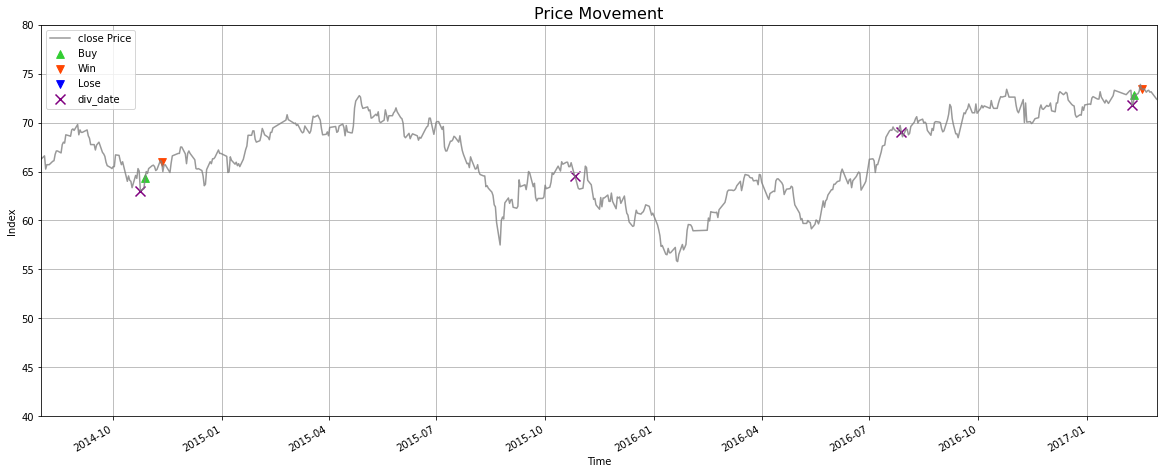

In [92]:
# 實際交易位置
List = []
for i in range(len(df)):
  if df[symbol][i] > 0:
    List.append(df.index[i])

print('buy:{}'.format(df.iloc[buy].index))
print('win:{}'.format(df.iloc[sell_win].index))
print('lose:{}'.format(df.iloc[sell_lose].index))
print('--------------')
print('win ratio :{}'.format(len(sell_win)/len(buy)))

fig, ax = plt.subplots(figsize = (20,8))
df['close'].plot(label = 'close Price', ax = ax, c = 'gray', grid=True, alpha=0.8)
plt.scatter(df['close'].iloc[buy].index, df['close'].iloc[buy],c = 'limegreen', label = 'Buy', marker='^', s=60)
plt.scatter(df['close'].iloc[sell_win].index, df['close'].iloc[sell_win],c = 'orangered', label = 'Win', marker='v', s=60)
plt.scatter(df['close'].iloc[sell_lose].index, df['close'].iloc[sell_lose],c = 'b', label = 'Lose', marker='v', s=60)
plt.scatter(df['close'].loc[List].index, df['close'].loc[List],c = 'purple', label = 'div_date', marker='x', s=100)

plt.xlim('2014-08-01', '2017-03-01')
plt.ylim(40, 80)

plt.legend()
plt.ylabel('Index')
plt.xlabel('Time')
plt.title('Price Movement',fontsize  = 16);

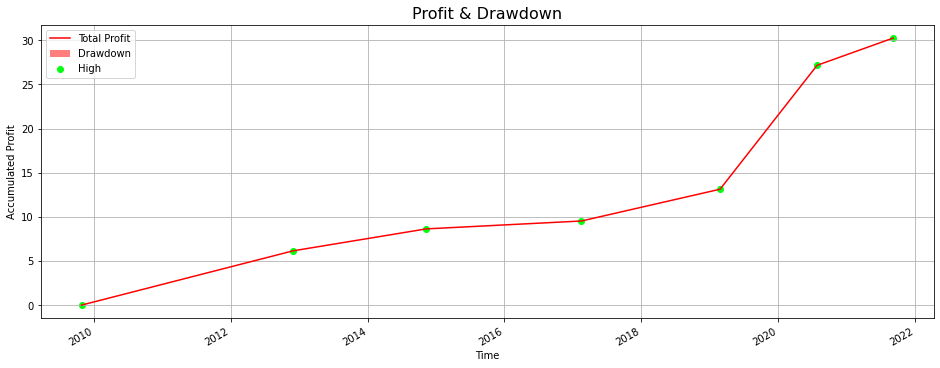

In [93]:
equity['equity'] = equity['profit'] + fund
equity['drawdown_percent'] = (equity['equity'] / equity['equity'].cummax()) - 1
equity['drawdown'] = equity['equity'] - equity['equity'].cummax()

fig, ax = plt.subplots(figsize = (16,6))

high_index = equity[equity['profit'].cummax() == equity['profit']].index
equity['profit'].plot(label = 'Total Profit', ax = ax, c = 'r', grid=True)
plt.fill_between(equity['drawdown'].index, equity['drawdown'], 0, facecolor  = 'r', label = 'Drawdown', alpha=0.5)
plt.scatter(high_index, equity['profit'].loc[high_index],c = '#02ff0f', label = 'High')

plt.legend()
plt.ylabel('Accumulated Profit')
plt.xlabel('Time')
plt.title('Profit & Drawdown',fontsize  = 16);


##for all

0050 is weird...

In [94]:
opt_pct = 35
opt_earn = 14 * 0.1
opt_loss = 7 * 0.1

symbol = '0050.TW'
print(f'---loading: {symbol}---')
data = yf.Ticker(symbol)
df = data.history(period='D', start='2009-10-26', end='2022-6-30')
df = df.drop(columns = ['Dividends', 'Stock Splits'])
df.columns = ['open', 'high', 'low', 'close', 'volume']
df['SAR'] = abstract.SAR(df)
df['pct_30'] = df['close'].pct_change(opt_pct)
df['pct_1'] = df['close'].pct_change(1)

Yield = pd.read_csv(path + '/yield.csv')
Yield = Yield.set_index(pd.to_datetime(Yield['Date']))
Yield = Yield.drop('Date', axis = 1)
df = pd.merge(df, Yield, how = 'left', left_index = True, right_index=True)

fund = 100 
money = 100 
feeRate = 0.003

first = 0 
BS = None 
stopEarn = 0
stopLoss = 0

#--------# 記錄買入、賣出時間點
buy = []
sell_win = []
sell_lose = []
#--------# 
timeList = [] 
profit_list = [0]
profit_fee_list = [0]

#--------# ratio cal.
win_ratio = []
err_ratio = []


for i in range(len(df)):

    if first == 0:
        timeList.append(df.index[i+1])
        first = 1
        continue

    if i == len(df)-1: # last trading day
        break
     
      # 除息日                      # BS: position, B: buy, S: sell
    if df[symbol][i] > 0 and abs(df['pct_30'][i]) > abs(df['pct_30'][i-1]) * 1.5 and BS == None: # and abs(df['pct_30'][i]) > abs(df['pct_30'][i-1]) * 3
        BS = 'OK' 
        continue

      # buy
    if BS == 'OK' and df['pct_1'][i] > 0: # 等反轉再進場
        temp = df['close'][i+1] 
        tempSize = money / temp
        BS = 'B' 
        buy.append(i+1)
        stopLoss = df['SAR'][i+1] * opt_loss
        stopEarn = df['close'][i+1] + (abs((df['close'][i+1] - df['SAR'][i+1])) * opt_earn)
        continue

      # 極端值停利
    if df['pct_1'][i] > 0.07 and df['close'][i] > temp and BS == 'B':
        profit = tempSize * (df['close'][i] - temp) 
        profit_fee = profit - money*feeRate - (money+profit)*feeRate
        profit_fee_list.append(profit_fee)
        profit_list.append(profit)
        sell_win.append(i)
        timeList.append(df.index[i])
        BS=None
        continue
        
      # 停利
    if df['close'][i] > stopEarn and BS == 'B':
        profit = tempSize * (df['close'][i+1] - temp) 
        profit_fee = profit - money*feeRate - (money+profit)*feeRate
        profit_fee_list.append(profit_fee)
        profit_list.append(profit)
        sell_win.append(i+1)
        timeList.append(df.index[i])
        BS=None
        continue

      # 停損
    if df['close'][i] < stopLoss and BS == 'B':
        profit = tempSize * (df['close'][i+1] - temp) 
        profit_fee = profit - money*feeRate - (money+profit)*feeRate
        profit_fee_list.append(profit_fee)
        profit_list.append(profit)
        sell_lose.append(i+1)
        timeList.append(df.index[i])
        BS=None
        continue
    
equity = pd.DataFrame({'0050.TW':np.cumsum(profit_list)}, index=timeList)
win_ratio.append(len(sell_win)/len(buy))

########-------------------------------------------------------------#########

symbol_list = ['0051.TW', '0052.TW', '0053.TW', '0055.TW', '0056.TW', '006203.TW', '006204.TW', '006208.TW', 
               '00690.TW', '00692.TW', '00701.TW', '00712.TW', '00713.TW', '00714.TW', '00717.TW',
               '00728.TW', '00730.TW', '00731.TW', '00733.TW', '00735.TW']

for j in range(len(symbol_list)):
  symbol = symbol_list[j]

  print(f'---loading: {symbol}---')

  data = yf.Ticker(symbol)
  df = data.history(period='D', start='2009-10-26', end='2022-6-30')
  df = df.drop(columns = ['Dividends', 'Stock Splits'])
  df.columns = ['open', 'high', 'low', 'close', 'volume']
  df['SAR'] = abstract.SAR(df)
  df['pct_30'] = df['close'].pct_change(opt_pct)
  # df['rolling'] = df['close'].rolling(10, win_type ='triang').std()
  df['pct_1'] = df['close'].pct_change(1)

  df = pd.merge(df, Yield, how = 'left', left_index = True, right_index=True)

  first = 0 ##除了第一筆之外，只紀錄出場的時間點
  BS = None ##紀錄現在的狀態是做多還做空
  stopEarn = 0
  stopLoss = 0

  #--------# 記錄買入、賣出時間點
  buy = []
  sell_win = []
  sell_lose = []
  #--------# 
  timeList = [] 
  profit_list = [0]
  profit_fee_list = [0]


  for i in range(len(df)):

      if first == 0:
          timeList.append(df.index[i+1])
          first = 1
          continue

      if i == len(df)-1: # last trading day
          break
      
          # 除息日                      # BS: position, B: buy, S: sell
      if df[symbol][i] > 0 and abs(df['pct_30'][i]) > abs(df['pct_30'][i-1]) * 1.5 and BS == None: # and abs(df['pct_30'][i]) > abs(df['pct_30'][i-1]) * 3
          BS = 'OK' 
          continue

        # buy
      if BS == 'OK' and df['pct_1'][i] > 0: # 等反轉再進場
          temp = df['close'][i+1] 
          tempSize = money / temp
          BS = 'B' 
          buy.append(i+1)
          stopLoss = df['SAR'][i+1] * opt_loss
          stopEarn = df['close'][i+1] + (abs((df['close'][i+1] - df['SAR'][i+1])) * opt_earn)
          continue

        # 極端值停利
      if df['pct_1'][i] > 0.08 and df['close'][i] > temp and BS == 'B':
          profit = tempSize * (df['close'][i] - temp) 
          profit_fee = profit - money*feeRate - (money+profit)*feeRate
          profit_fee_list.append(profit_fee)
          profit_list.append(profit)
          sell_win.append(i)
          timeList.append(df.index[i])
          BS=None
          continue
          
        # 停利
      if df['close'][i] > stopEarn and BS == 'B':
          profit = tempSize * (df['close'][i+1] - temp) 
          profit_fee = profit - money*feeRate - (money+profit)*feeRate
          profit_fee_list.append(profit_fee)
          profit_list.append(profit)
          sell_win.append(i+1)
          timeList.append(df.index[i])
          BS=None
          continue

        # 停損
      if df['close'][i] < stopLoss and BS == 'B':
          profit = tempSize * (df['close'][i+1] - temp) 
          profit_fee = profit - money*feeRate - (money+profit)*feeRate
          profit_fee_list.append(profit_fee)
          profit_list.append(profit)
          sell_lose.append(i+1)
          timeList.append(df.index[i])
          BS=None
          continue
      
  pp = pd.DataFrame({'{}'.format(symbol_list[j]):profit_list}, index=timeList)
  equity = pd.concat([equity,pp], join='outer', axis=1)

  if len(buy) == 0:
    err_ratio.append('{} is NA'.format(symbol))
  else:
    win_ratio.append((len(sell_win)/len(buy)))

---loading: 0050.TW---
---loading: 0051.TW---
---loading: 0052.TW---
---loading: 0053.TW---
---loading: 0055.TW---
---loading: 0056.TW---
---loading: 006203.TW---
---loading: 006204.TW---
---loading: 006208.TW---
---loading: 00690.TW---
---loading: 00692.TW---
---loading: 00701.TW---
---loading: 00712.TW---
---loading: 00713.TW---
---loading: 00714.TW---
---loading: 00717.TW---
---loading: 00728.TW---
---loading: 00730.TW---
---loading: 00731.TW---
---loading: 00733.TW---
---loading: 00735.TW---


In [81]:
np.cumsum(equity, axis = 0)

,0050.TW,0051.TW,0052.TW,0053.TW,0055.TW,0056.TW,006203.TW,006204.TW,006208.TW,00690.TW,...,00701.TW,00712.TW,00713.TW,00714.TW,00717.TW,00728.TW,00730.TW,00731.TW,00733.TW,00735.TW
2009-10-27,0.000000,0.000000,0.0,0.0,0.000000,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-12-02,NaN,3.982599,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-12-06,NaN,NaN,NaN,NaN,7.254741,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-04-22,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-09-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.643772,NaN,NaN,NaN,NaN,NaN
2021-09-06,94.827337,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,11.104067,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-09,NaN,NaN,NaN,NaN,NaN,42.069689,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [95]:
equity = equity.fillna(0)
df_ATC = equity.sum(axis = 0)
print(df_ATC, f'mean : {df_ATC.mean()}')

0050.TW      94.827337
0051.TW      41.476324
0052.TW      45.133402
0053.TW      20.793492
0055.TW      33.945573
0056.TW      42.069689
006203.TW    35.437963
006204.TW     6.190473
006208.TW    17.154203
00690.TW      0.000000
00692.TW      9.530660
00701.TW      3.253590
00712.TW     11.104067
00713.TW      8.008506
00714.TW     12.670492
00717.TW      2.643772
00728.TW      7.266437
00730.TW      7.400719
00731.TW      6.037656
00733.TW      0.000000
00735.TW      5.766951
dtype: float64 mean : 19.557681270453255


In [96]:
mean_win_ratio = sum(win_ratio)/len(win_ratio)
win_ratio, err_ratio, mean_win_ratio

([1.0,
  1.0,
  0.75,
  1.0,
  1.0,
  1.0,
  1.0,
  0.5,
  1.0,
  1.0,
  1.0,
  0.6666666666666666,
  1.0,
  1.0,
  0.6666666666666666,
  1.0,
  1.0,
  1.0,
  1.0],
 ['00690.TW is NA', '00733.TW is NA'],
 0.9254385964912281)

# End